In [8]:
import pandas as pd
from pandas.plotting import radviz
import matplotlib.pyplot as plt

In [1]:
%config InlineBackend.figure_format = "svg"

In [3]:
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class'] #设置表头
dataset = pd.read_csv('Iris.txt', names=names) # 读取数据

In [5]:
dataset

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


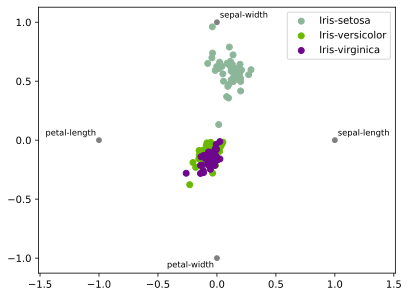

In [11]:
fig = radviz(dataset,'class')
plt.savefig("radviz.svg", dpi=300,format="svg")

In [46]:
import os
import argparse
import numpy as np
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
from sklearn.tree import DecisionTreeClassifier

In [33]:
def load_data_and_split(data_path:str, val_rate:float):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表，训练集标签列表，验证集标签列表
    """
    with open(data_path,'r') as openfile:
        data_lines = openfile.read().splitlines()  # 读取文件的所有行，忽略换行符
    data_lines = list(set(data_lines))
    data_list,label_list = [],[]
    for data_line in data_lines:
        data_line = data_line.split(",")
        data_list.append(list(map(float,data_line[0:-1])))
        label_list.append(data_line[-1])
    train_data, val_data, train_label, val_label = train_test_split(data_list, label_list, test_size=val_rate, 
                                                                        random_state=random.randint(0,1000),shuffle=True)
    return np.array(train_data),np.array(val_data), np.array(train_label),np.array(val_label)

In [9]:
def get_distance(x,y):
    """
    :return: 返回两个向量欧式距离的平方
    """
    return np.sum((np.array(x)-np.array(y))**2,axis=1)

In [64]:
def multi_times_test(k, times,data_path,val_rate):
    self_knn_acc_list, std_knn_acc_list, mnb_acc_list, dtc_acc_list = [],[],[],[]
    for time in range(times):
        train_data, val_data, train_label, val_label = load_data_and_split(data_path=data_path, 
                                                                           val_rate=val_rate)
        acc = 0
        for index, val_one_data in enumerate(val_data):
            all_distance = get_distance(val_one_data, train_data)  # 计算当前向量与所有向量的距离
            min_k_distance_label = train_label[all_distance.argsort()[0:k]]  # 当前向量距离最近的k个向量的标签
            count_all_label = Counter(min_k_distance_label)  # 用Counter类统计k个向量中各个标签的数量
            predict_label = count_all_label.most_common(1)[0][0]  # 预测标签
            if predict_label == val_label[index]:
                acc = acc + 1  # 预测正确
#         print('The accuracy of self_KNN is {:.3f}%'.format(acc / len(val_label) * 100))
        self_knn_acc_list.append(round(acc / len(val_label)*100,3))

        knc = KNeighborsClassifier()
        knc.fit(train_data, train_label)
#         print('The accuracy of kNN is {:.3f}%'.format(knc.score(val_data, val_label) * 100))
        std_knn_acc_list.append(round(knc.score(val_data, val_label)*100,3))

        mnb = CategoricalNB()
        mnb.fit(train_data, train_label)
#         print('The accuracy of mnb is {:.3f}%'.format(mnb.score(val_data, val_label) * 100))
        mnb_acc_list.append(round(mnb.score(val_data, val_label)*100,3))
        
        dtc = DecisionTreeClassifier()
        dtc.fit(train_data, train_label)
#         print('The accuracy of dtc is {:.3f}%'.format(dtc.score(val_data, val_label) * 100))
        dtc_acc_list.append(round(dtc.score(val_data, val_label)*100,3))
    return round(np.mean(self_knn_acc_list),3),\
           round(np.mean(std_knn_acc_list),3),\
           round(np.mean(mnb_acc_list),3),\
           round(np.mean(dtc_acc_list),3)

In [103]:
times = 5
data_path = "./Iris.txt"
val_rate = 0.2
k_list = [i for i in range(3,9)]
self_knn_acc_list, std_knn_acc_list, mnb_acc_list, dtc_acc_list = [],[],[],[]
for k in k_list:
    self_knn_acc,std_knn_acc,mnb_acc,dtc_acc = multi_times_test(k,times,data_path,val_rate)
    self_knn_acc_list.append(self_knn_acc)
    std_knn_acc_list.append(std_knn_acc)
    mnb_acc_list.append(mnb_acc)
    dtc_acc_list.append(dtc_acc)
print(self_knn_acc_list)
print(std_knn_acc_list)
print(mnb_acc_list)
print(dtc_acc_list)

[96.0, 95.333, 98.667, 96.0, 94.0, 96.667]
[96.667, 94.666, 98.667, 96.0, 94.0, 96.0]
[94.667, 94.0, 96.0, 94.0, 92.0, 94.667]
[97.333, 95.333, 96.667, 94.0, 91.333, 96.0]


In [86]:
import matplotlib.pyplot as plt

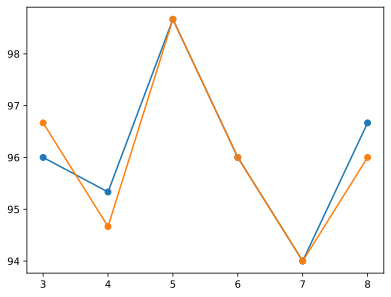

In [104]:
fig, aix = plt.subplots()
aix.scatter(k_list,self_knn_acc_list)
aix.plot(k_list,self_knn_acc_list)
aix.scatter(k_list,std_knn_acc_list)
aix.plot(k_list,std_knn_acc_list)